<a href="https://colab.research.google.com/github/SooperDoop/ai-examples/blob/master/sparktry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz 
!tar --extract --file  spark-2.4.0-bin-hadoop2.7.tgz
!pip install  findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
print('setup--complete')

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
from google.colab import files
files.upload()

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
dataset = spark.read.csv('sample_data/california_housing_train.csv',inferSchema=True, header =True)

In [0]:
dataset.select('median_house_value').show()

In [0]:
dataset.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)



In [0]:
assem = VectorAssembler(inputCols=['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income'],outputCol='Attributes')
output = assem.transform(dataset)

final_dataset = output.select('Attributes','median_house_value')

In [0]:
output.select('Attributes').show(1)

+--------------------+
|          Attributes|
+--------------------+
|[-114.31,34.19,15...|
+--------------------+
only showing top 1 row



In [0]:
train ,test = final_dataset.randomSplit([0.8,0.2])

In [0]:
model = LinearRegression(featuresCol='Attributes',labelCol='median_house_value')
# model = RandomForestRegressor(featuresCol='Attributes',labelCol='median_house_value')
model = model.fit(train)
res = model.evaluate(test)
res.predictions.show()

In [0]:
res.r2,res.meanAbsoluteError,res.meanSquaredError,res.rootMeanSquaredError

(0.6547799761654571, 51233.4162492237, 4785641428.557008, 69178.33062857912)

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
eva = RegressionEvaluator(predictionCol='prediction',labelCol='median_house_value',metricName='rmse')
print(eva.evaluate(res.predictions),' : RMSE')
print(eva.evaluate(res.predictions,{eva.metricName:'r2'}),' : R2')
print(eva.evaluate(res.predictions,{eva.metricName:'mae'}),' : MAE')
print(eva.evaluate(res.predictions,{eva.metricName:'mse'}),' : MSE')

69178.33062857912  : RMSE
0.6547799761654571  : R2
51233.4162492237  : MAE
4785641428.557008  : MSE


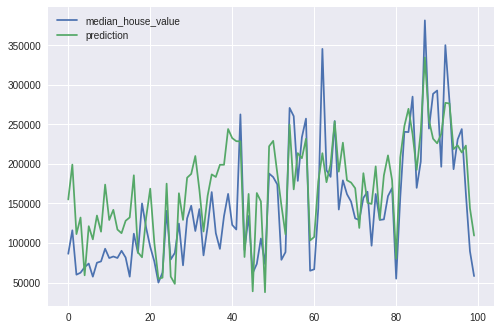

In [0]:
res.predictions.toPandas()[:100].plot()
# plt.show()

In [0]:
words_new = spark.broadcast(["scala", "java", "hadoop", "spark", "akka"]) 
data = words_new.value 
# print "Stored data -> %s" % (data) 
elem = words_new.value[2] 
print (elem)

In [0]:
!ls

 sample_data			'test_oJQbWVk (1).csv'
 spark-2.4.0-bin-hadoop2.7	'train_2kmZucJ (1).csv'
 spark-2.4.0-bin-hadoop2.7.tgz


In [0]:
import pandas as pd
import numpy as np
import spacy
from tqdm import tqdm
import re
import time
import pickle
pd.set_option('display.max_colwidth', 200)

In [0]:
train = pd.read_csv(r'train_2kmZucJ (1).csv',index_col='id')
test = pd.read_csv(r'test_oJQbWVk (1).csv',index_col='id')

In [0]:
train['label'].value_counts(normalize=True)

0    0.744192
1    0.255808
Name: label, dtype: float64

In [0]:
train['clean_tweet']=train['tweet'].apply(lambda x:re.sub('http\S+','',x))
test['clean_tweet']=test['tweet'].apply(lambda x:re.sub('https\S+','',x))

In [0]:
punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'
train['clean_tweet']=train['clean_tweet'].apply(lambda x:''.join(ch for ch in x if ch not in set(punctuation)))
test['clean_tweet']=test['clean_tweet'].apply(lambda x:''.join(ch for ch in x if ch not in set(punctuation)))

test['clean_tweet'] = test['clean_tweet'].str.lower()
train['clean_tweet'] = train['clean_tweet'].str.lower()

train['clean_tweet'] = train['clean_tweet'].str.replace('[0-9]','')
test['clean_tweet'] = test['clean_tweet'].str.replace('[0-9]','')

train['clean_tweet'] = train['clean_tweet'].apply(lambda x:' '.join(x.split()))
test['clean_tweet'] = test['clean_tweet'].apply(lambda x:' '.join(x.split()))


In [0]:

train['tweet'][1],train['clean_tweet'][1]

('#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone',
 'fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone')

In [0]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer=WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:

# lemmatizer.lemmatize('done')
# input_str='been had done languages cities mice'
# input_str=word_tokenize()
# for word in c:
#     print(lemmatizer.lemmatize(word))

In [0]:
train['clean_tweet'] = train['clean_tweet'].apply(lambda x: lemmatizer.lemmatize(x))
test['clean_tweet'] = test['clean_tweet'].apply(lambda x:lemmatizer.lemmatize(x))

In [0]:
train.head()

,label,tweet,clean_tweet
id,,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone,fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone
2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/,finally a transparant silicon case thanks to my uncle yay sony xperia s sonyexperias…
3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu,we love this would you go talk makememories unplug relax iphone smartphone wifi connect...
4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/,i'm wired i know i'm george i was made that way iphone cute daventry home
5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!,what amazing service apple won't even talk to me about a question i have unless i pay them . for their stupid support


In [0]:
import tensorflow_hub as hub
import tensorflow as tf

elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

W0321 12:21:54.887797 139734327023488 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14
W0321 12:21:55.596192 139734327023488 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [0]:
embeddings = elmo(["fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone"], signature="default", as_dict=True)["elmo"]

embeddings.shape

TensorShape([Dimension(1), Dimension(12), Dimension(1024)])

In [0]:
def elmo_vectors(x):
  embeddings = elmo(x.tolist(), signature="default", as_dict=True)["elmo"]

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    # return average of ELMo features
    return sess.run(tf.reduce_mean(embeddings,1))

In [0]:
list_train = [train[i:i+100] for i in range(0,train.shape[0],100)]
list_test = [test[i:i+100] for i in range(0,test.shape[0],100)]

In [0]:
elmo_train = [elmo_vectors(x['clean_tweet']) for x in list_train]
elmo_test = [elmo_vectors(x['clean_tweet']) for x in list_test]

NameError: ignored